<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [49]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
#from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import math
from datetime import datetime

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('.')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [94]:
def prepare_train_set_with_fe(path, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    sets = np.sort(glob(path + '/*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    final_data = []
    for one_set in sets:
        data = pd.read_csv(one_set)
        data.timestamp = data.timestamp.apply(pd.to_datetime)
        data_set = data.values
        user_id = int(one_set[one_set.find('/user')+5:-4])
        count = math.ceil(len(data)/window_size)
        for n in range(int(count)):
            session = {'target': user_id}
            for i in range(session_length):
                code = 0
                diff = 0
                if (n*window_size+i < len(data)):
                    site_name = data_set[n*window_size+i,1]
                    time = data_set[n*window_size+i,0]
                    code = site_freq[site_name][0]
                    if (i != 0):
                        diff = int((time - data_set[n*window_size+i - 1,0]).total_seconds())
                session[i+1] = code
                if (i != 0):
                    session[session_length + i] = diff
            session[session_length*2] = np.sum([session[j] for j in range(session_length + 1, session_length*2)])
            unique = np.unique([session[j] for j in range(1,session_length+1)])
            session[session_length*2 + 1] = len(unique[unique > 0])
            time_min = data_set[n*window_size,0]
            session[session_length*2 + 2] =  time_min.hour
            session[session_length*2 + 3] =  time_min.weekday()
            final_data.append(session)
    final_frame = pd.DataFrame(final_data)
    final_frame.columns = feature_names
    return final_frame

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [96]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [97]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 35.9 s, sys: 536 ms, total: 36.4 s
Wall time: 36.6 s


In [98]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [99]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 7min 24s, sys: 17.8 s, total: 7min 42s
Wall time: 7min 53s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [104]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour','day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour','day_of_week']]

In [105]:
new_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week
0,33,5,8,4
1,284,10,8,4
2,258,7,8,4
3,30,6,8,4
4,6,9,8,4


In [106]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [107]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [108]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

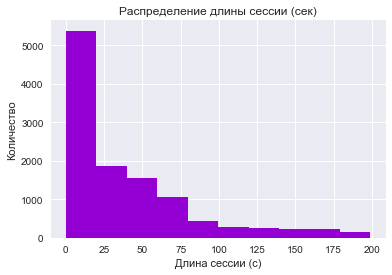

In [124]:
ax = train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].hist(color='darkviolet')    
ax.set_xlabel('Длина сессии (с)'.decode('utf8'))
ax.set_ylabel('Количество'.decode('utf8'))
ax.set_title('Распределение длины сессии (сек)'.decode('utf8'))

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

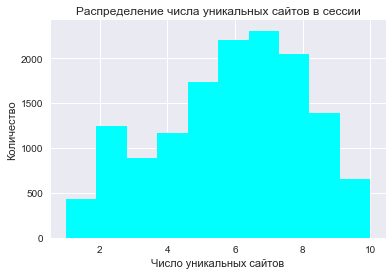

In [125]:
ax = train_data_10users['#unique_sites'].hist(color = 'aqua')
ax.set_xlabel('Число уникальных сайтов'.decode('utf8'))
ax.set_ylabel('Количество'.decode('utf8'))
ax.set_title('Распределение числа уникальных сайтов в сессии'.decode('utf8'))

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

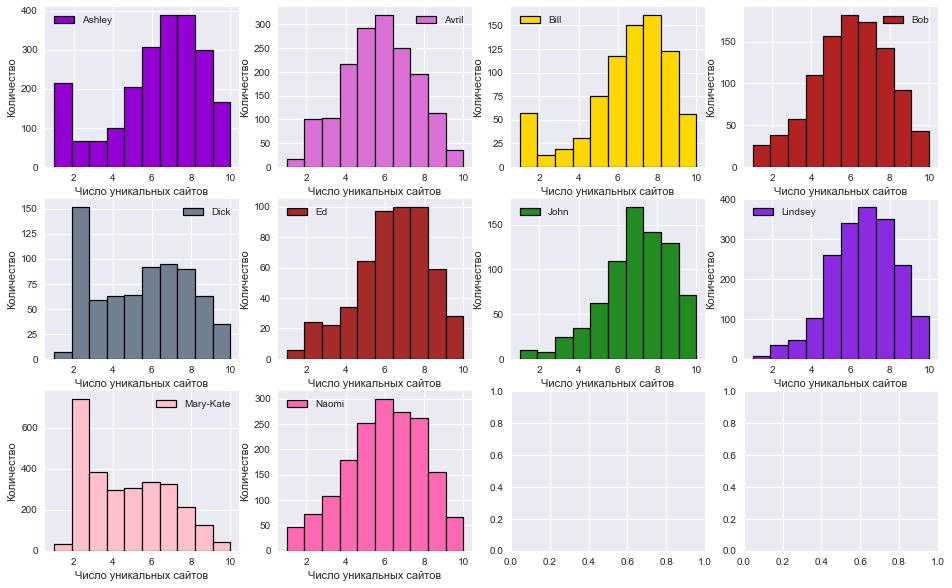

In [235]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['#unique_sites'].hist(ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user,
                                     edgecolor='black', linewidth=1.2)
    ax.set_xlabel('Число уникальных сайтов'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

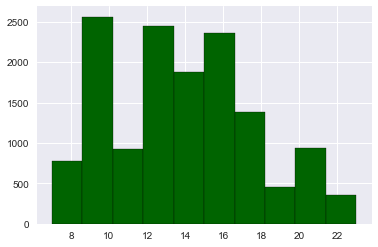

In [234]:
train_data_10users['start_hour'].hist(color = 'darkgreen',edgecolor='black')
ax.set_xlabel('Час начала сессии'.decode('utf8'))
ax.set_ylabel('Количество'.decode('utf8'))
ax.set_title('Распределение часа начала сессии'.decode('utf8'))

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

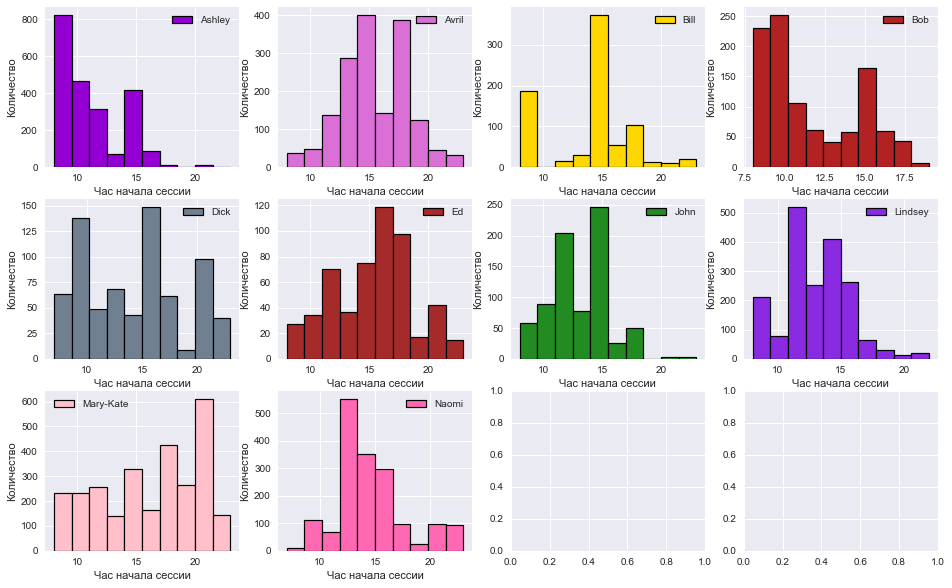

In [233]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['start_hour'].plot(kind='hist',ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user,
                                  edgecolor='black', linewidth=1.2)
    ax.set_xlabel('Час начала сессии'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

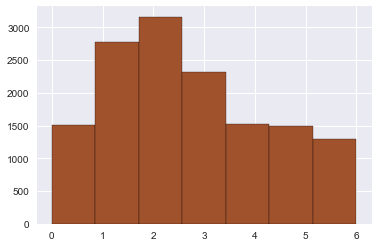

In [232]:
train_data_10users['day_of_week'].hist(color = 'sienna', bins=7, edgecolor='black')
ax.set_xlabel('День недели'.decode('utf8'))
ax.set_ylabel('Количество'.decode('utf8'))
ax.set_title('Распределение дня недели'.decode('utf8'))

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

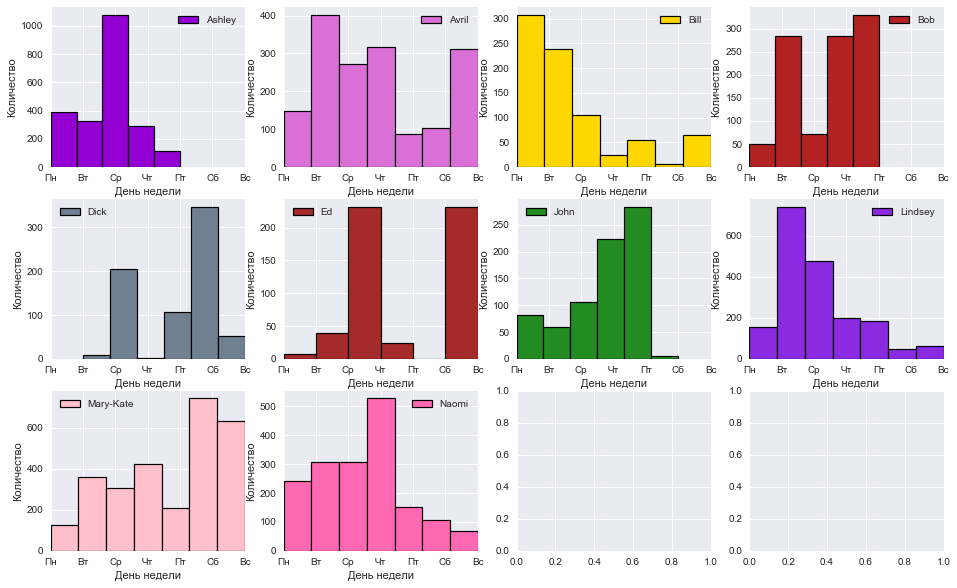

In [228]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['day_of_week'].hist(ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user,
                                   edgecolor='black', linewidth=1.2, bins=np.unique(sub_df['day_of_week']).shape[0])
    ax.set_xlabel('День недели'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.set_xticklabels(['Пн'.decode('utf8'), 'Вт'.decode('utf8'), 'Ср'.decode('utf8'), 'Чт'.decode('utf8'), 
                        'Пт'.decode('utf8'), 'Сб'.decode('utf8'), 'Вс'.decode('utf8')] )
    ax.set_xlim(0,6)
    ax.legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По полученным данным можно сделать вывод о том, что каждый пользователь имеет определенные поведенческие особенности в посещении сайтов - например, дни недели, когда он больше всего проводит в интернете, либо время суток. Пользователь Ashley значительно больше времени проводит в интернете по четвергам, а пользователи Dick и John - по субботам. Также и у остальных пользователей есть такой особенный день недели, это четко видно из построенных гистограмм распределения дня недели, в который начинается каждая сессия. Еще одним признаком, характеризующим поведение пользователя, является число уникальных сайтов за сессию. Например, у большинства пользователей мода распределения находится в районе значения, равного 7, но у пользователя Dick данное значение равно 2.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [153]:
site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with open(site_freq_path, 'rb') as f:
        site_10users_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [154]:
top10_popular = sorted(site_10users_freq.items(), key=lambda x: x[1][1], reverse=True)[:10]
top10_freqs = map(lambda x: x[1][1], top10_popular)
top10_sites = map(lambda x: x[0], top10_popular)

In [156]:
print(top10_sites)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

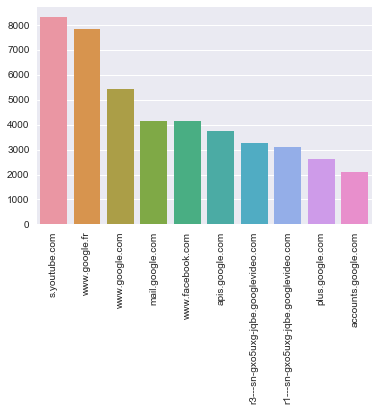

In [166]:
ax = sns.barplot(x=top10_sites, y=top10_freqs )
ax.set_xticklabels(top10_sites,rotation = 90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [167]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [168]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [169]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [170]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [219]:
def feature_engineering(path, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    sets = np.sort(glob(path + '/*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    top10_popular = sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:10]
    top10_sites = map(lambda x: x[1][0], top10_popular)
    final_data = []
    for one_set in sets:
        data = pd.read_csv(one_set)
        data.timestamp = data.timestamp.apply(pd.to_datetime)
        data_set = data.values
        user_id = int(one_set[one_set.find('/user')+5:-4])
        count = math.ceil(len(data)/window_size)
        for n in range(int(count)):
            session = []
            session_new = {'target': user_id}
            for i in range(session_length):
                code = 0
                if (n*window_size+i < len(data)):
                    site_name = data_set[n*window_size+i,1]
                    time = data_set[n*window_size+i,0]
                    code = site_freq[site_name][0]
                session.append(code)
                for j,site_pop in enumerate(top10_sites):
                    session_new[session_length + 10 + j + 1] = np.sum(map(lambda x: 1 if x==site_pop else 0, session))
                    ind = 0
                    if (session_new[session_length + 10 + j + 1] > 0):
                        ind = 1
                    session_new[session_length + j + 1] = ind
            final_data.append(session_new)
    final_frame = pd.DataFrame(final_data)
    final_frame.columns = feature_names
    return final_frame

In [221]:
%%time
feature_names = ['top_site_ind' + str(i) for i in range(1,11)] + \
                ['top_site_count' + str(j) for j in range(1,11)] + ['target']
new_features_10users  = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 1min 14s, sys: 364 ms, total: 1min 14s
Wall time: 1min 13s


In [213]:
new_features_10users.head()

,top_site_ind1,top_site_ind2,top_site_ind3,top_site_ind4,top_site_ind5,top_site_ind6,top_site_ind7,top_site_ind8,top_site_ind9,top_site_ind10,top_site_count1,top_site_count2,top_site_count3,top_site_count4,top_site_count5,top_site_count6,top_site_count7,top_site_count8,top_site_count9,top_site_count10,target
0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,31
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
2,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,31
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,31


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [222]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

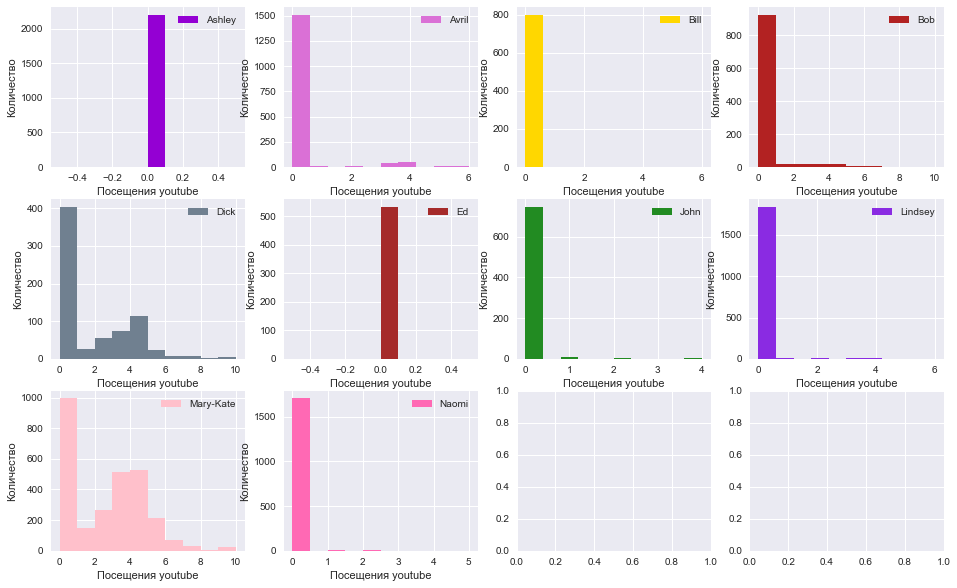

In [225]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = sub_df['top_site_count1'].plot(kind='hist',ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user)
    ax.set_xlabel('Посещения youtube'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.legend()

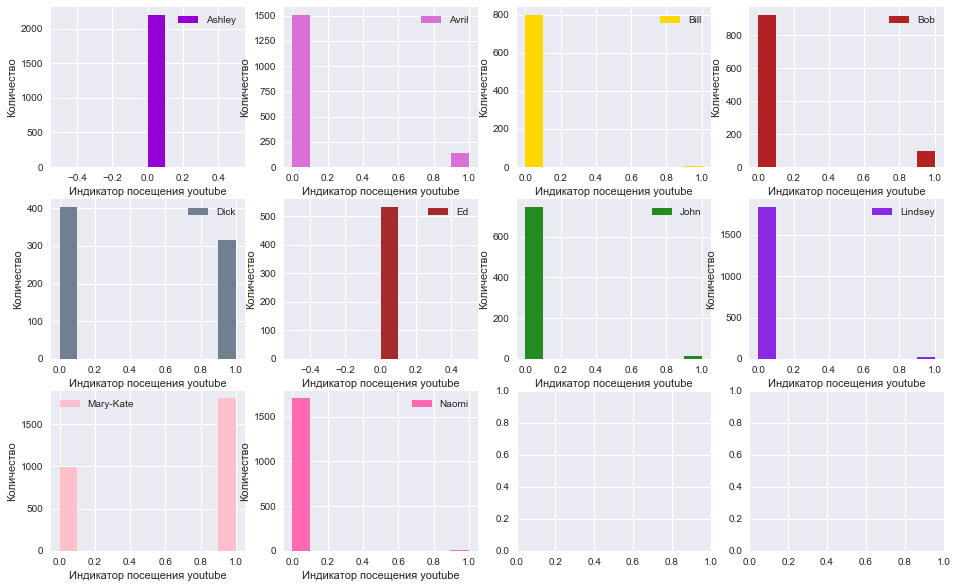

In [226]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = sub_df['top_site_ind1'].plot(kind='hist',ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user)
    ax.set_xlabel('Индикатор посещения youtube'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.legend()

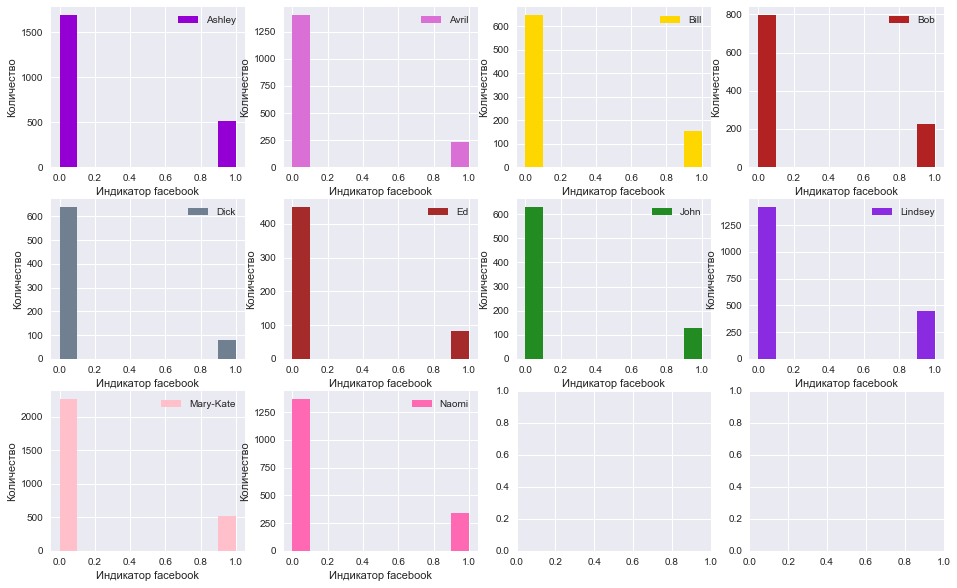

In [227]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = sub_df['top_site_ind5'].plot(kind='hist',ax=axes[int(idx / 4), int(idx % 4)],color = color_dic[user],label=user)
    ax.set_xlabel('Индикатор facebook'.decode('utf8'))
    ax.set_ylabel('Количество'.decode('utf8'))
    ax.legend()

Из гистограмм видно, что для некоторых пользователей посещение определенных сайтов абсолютно не свойственно: например, пользователь Ashley никогда не заходит на youtube. Либо же наоборот, посещение какого-то сайта хотя бы раз за сессию более вероятно, чем непосещение: как это видно из гистограммы посещений youtube для Mary-Kate. А вот вероятность посещения facebook для всех пользователей примерно одинакова.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 